#Paper Rock Scissors CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.10.1


#Split Datasets

In [2]:
# split 60 % data to train dataset in batch dataset
train_ds = keras.utils.image_dataset_from_directory(
  'dataset',
  validation_split=0.4,
  subset="training",
  seed=42,
  image_size=(150, 150),
  batch_size=32)

Found 2188 files belonging to 3 classes.
Using 1313 files for training.


In [3]:
# split 40 % data to validation dataset in batch dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset',
  validation_split=0.4,
  subset="validation",
  seed=42,
  image_size=(150, 150),
  batch_size=32)

Found 2188 files belonging to 3 classes.
Using 875 files for validation.


In [4]:
# check label names
label_names = train_ds.class_names
print(label_names)

['paper', 'rock', 'scissors']


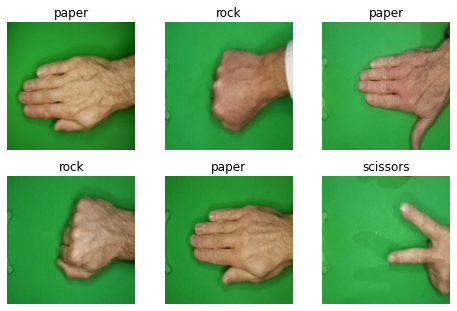

In [5]:
# check image with label
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

##Data Augmentation

In [6]:
def rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 255.0)
  return image, label

In [7]:
# function of image augmentation

def augmentation(image_label, seed):
  image, label = image_label
  image = tf.image.stateless_random_flip_left_right(image, seed)
  image = tf.image.stateless_random_saturation(image, 0.5, 1.0, seed)
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.3, seed=seed)
  return image, label

In [8]:
# generate random number generator for seed

rng = tf.random.Generator.from_seed(42, alg='philox')
seed = rng.make_seeds(2)[0]

In [9]:
# wrap function image augmentation

def wrap_augmentation(x, y):
  # x, y = rescale(x, y)
  image, label = augmentation((x, y), seed)
  return image, label

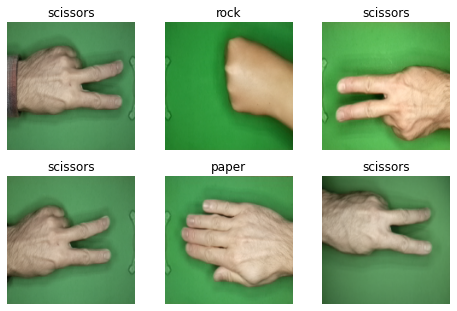

In [10]:
# check image with augmentation

plt.figure(figsize=(8, 8))
for images,labels in train_ds.take(1):
  for i in range(6):
    seed = (i, 0)
    augmented,lbl = augmentation((images[i], labels[i]), seed)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title(label_names[lbl])
    plt.axis("off")

In [11]:
# make train prefetch dataset

AUTOTUNE = tf.data.AUTOTUNE
train_pds = (
    train_ds
    .shuffle(1000)
    .map(wrap_augmentation, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [12]:
# make validation prefetch dataset

val_pds = (
    val_ds
    .prefetch(AUTOTUNE)
)

#Build Model CNN

In [13]:
# build model CNN
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Rescaling(1./255,input_shape=(150,150,3)))
model.add(Conv2D(15, 3, activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(45, 3, activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(60, 3, activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax' ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 15)      420       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 15)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 45)        6120      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 45)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 60)        2

In [14]:
# compile model with optimizer and loss function

from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer = Adam(learning_rate=0.0005),
              loss = SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
# make class callback with accuracy stopper and time stopper
import time

class callbacks(tf.keras.callbacks.Callback):
    '''callback for stopping training'''
    def __init__(self, max_time):
        super().__init__()
        self.max_time = max_time
        self.start_time = None
    def on_train_begin(self, logs):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        now = time.time()
        if(logs.get('accuracy') > 0.97):            
            self.model.stop_training = True       
        if now - self.start_time >  self.max_time:            
            self.model.stop_training = True

# stop when 30 minutes, 60 x 30 = 1800 s
callbacks = callbacks(1800)

In [16]:
# training model with 20 epoch

history = model.fit(
  train_pds,
  validation_data=val_pds,
  epochs=20,
  callbacks=[callbacks]
)

Epoch 1/20
42/42 [==============================] - 12s 259ms/step - loss: 1.0059 - accuracy: 0.4730 - val_loss: 0.7355 - val_accuracy: 0.7051
Epoch 2/20
42/42 [==============================] - 11s 259ms/step - loss: 0.5614 - accuracy: 0.7746 - val_loss: 0.8526 - val_accuracy: 0.7429
Epoch 3/20
42/42 [==============================] - 12s 266ms/step - loss: 0.3390 - accuracy: 0.8850 - val_loss: 0.3265 - val_accuracy: 0.8663
Epoch 4/20
42/42 [==============================] - 12s 268ms/step - loss: 0.1789 - accuracy: 0.9459 - val_loss: 0.2081 - val_accuracy: 0.9257
Epoch 5/20
42/42 [==============================] - 12s 274ms/step - loss: 0.1617 - accuracy: 0.9429 - val_loss: 0.2134 - val_accuracy: 0.9280
Epoch 6/20
42/42 [==============================] - 13s 297ms/step - loss: 0.0972 - accuracy: 0.9673 - val_loss: 0.1470 - val_accuracy: 0.9520
Epoch 7/20
42/42 [==============================] - 13s 294ms/step - loss: 0.1357 - accuracy: 0.9520 - val_loss: 0.1773 - val_accuracy: 0.9440

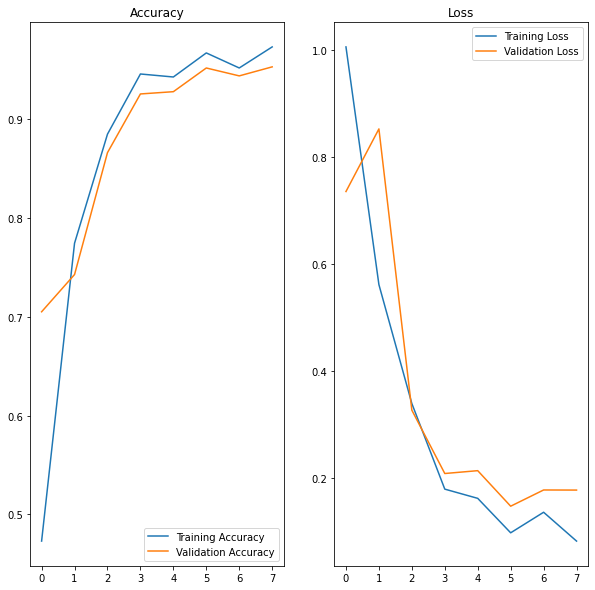

In [17]:
# show accuracy and loss graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

#Prediction Image

1/1 [==============================] - 0s 21ms/step


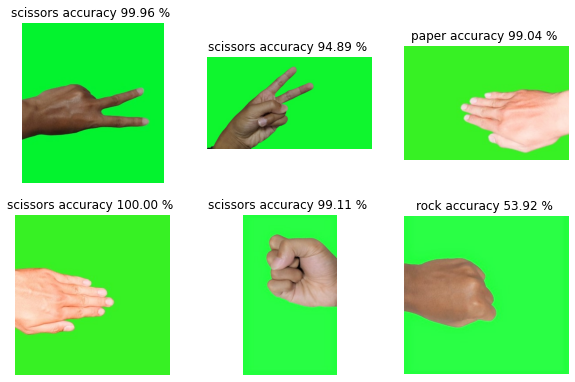

In [18]:
# predict images
import os
import matplotlib.image as mpimg
%matplotlib inline

folder_path = "test"

images_file = []
text_predict = []
for img in os.listdir(folder_path):
        img = os.path.join(folder_path, img)
    
        load_img = tf.keras.utils.load_img(img, target_size=(150, 150))
        img_array = tf.keras.utils.img_to_array(load_img)
        img_array = np.expand_dims(img_array, 0)

        images_file.append(mpimg.imread(img))
        images = np.vstack(img_array)
        predictions = model.predict(img_array, batch_size=1)
        str = "{} accuracy {:.2f} % ".format(label_names[np.argmax(predictions)], 100 * np.max(predictions))
        text_predict.append(str)

plt.figure(figsize=(10,10))
columns = 3
for i, image in enumerate(images_file):
    plt.subplot(int(len(images_file) / columns) + 1, columns, i + 1)
    plt.imshow(image)
    plt.title(text_predict[i])
    plt.axis("off")